# Based on 
https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/06_cuda_cnn_hooks_init.ipynb

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import fastai
import torch
fastai.__version__, torch.__version__

('1.0.52', '1.1.0')

# Some Import & Generic Code

In [0]:
from fastai.imports import *

In [0]:
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)
    
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train, y_train, x_valid, y_valid))

def normalize(x, mean, std_dev):
    return (x-mean)/std_dev

def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [0]:
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset
            
        
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=bs*2, **kwargs)
    )
            


# Create dataset and model

In [0]:
torch.set_num_threads(2)

In [0]:
x_train,y_train,x_valid,y_valid = get_data()
x_train, x_valid = normalize_to(x_train, x_valid)


In [0]:
train_ds = Dataset(x_train, y_train) 
valid_ds = Dataset(x_valid, y_valid) 

In [0]:
x_train.mean(), x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [0]:
nh, bs = 50, 512 # hidden , batch size
c = y_train.max().item() + 1
loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs),c )

In [0]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): 
        return self.func(x)

def flatten(x):  
    return x.view(x.shape[0], -1)

def mnist_resize(x): 
    return x.view(-1, 1, 28, 28)


def get_cnn_model(data):
#     import pdb; pdb.set_trace()
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1,  8, 5, padding=2, stride=2), nn.ReLU(), #14
        nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(), #7
        nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(), #4
        nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(), #2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )


In [0]:
model = get_cnn_model(data)

# Define call back, recorder, AvgStatsCallback

In [0]:
import re
from typing import *

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])

        
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train

    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)

    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn
            
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)

    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
def accuracy(out, yb): 
    return (torch.argmax(out, dim=1)==yb).float().mean()

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

 
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0

    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1

    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False


def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
#             import pdb; pdb.set_trace()
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break

        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

In [0]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [0]:
%time run.fit(1, learn)

train: [1.69343625, tensor(0.4119)]
valid: [0.53607822265625, tensor(0.8233)]
CPU times: user 6.02 s, sys: 284 ms, total: 6.3 s
Wall time: 3.87 s


# Well lets add Cuda support

In [0]:
device = torch.device('cuda',0)
torch.cuda.set_device(device)

class CudaCallback(Callback):
    def begin_fit(self): 
        self.model.cuda()
    def begin_batch(self): 
        self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()
        
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner



In [0]:
cbfs.append(CudaCallback)
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

model = get_cnn_model(data)
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)
%time run.fit(3, learn)

train: [2.1859015625, tensor(0.2155, device='cuda:0')]
valid: [1.4229423828125, tensor(0.5881, device='cuda:0')]
train: [0.6422330078125, tensor(0.7969, device='cuda:0')]
valid: [0.322864404296875, tensor(0.9095, device='cuda:0')]
train: [0.2130225390625, tensor(0.9353, device='cuda:0')]
valid: [0.17388939208984375, tensor(0.9460, device='cuda:0')]
CPU times: user 4.99 s, sys: 1.88 s, total: 6.87 s
Wall time: 6.89 s


# We will visualize std & mean at first few layers

In [0]:

class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            if self.training:
                self.act_means[i].append(x.data.mean())
                self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)
    

def get_cnn_model(data):
#     import pdb; pdb.set_trace()
    return [Lambda(mnist_resize) 
           ]+[ nn.Sequential( nn.Conv2d(1,  8, 5, padding=2, stride=2), nn.ReLU()) 
           ]+[ nn.Sequential( nn.Conv2d(8, 16, 3, padding=2, stride=2), nn.ReLU()) 
           ]+[ nn.Sequential( nn.Conv2d(16, 32, 3, padding=2, stride=2), nn.ReLU())
           ]+[ nn.Sequential( nn.Conv2d(32, 32, 3, padding=2, stride=2), nn.ReLU())
           ]+[nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(32, data.c)]

In [0]:
model =  SequentialModel(*get_cnn_model(data))
opt = optim.SGD(model.parameters(), lr=0.9)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)
%time run.fit(3, learn)

train: [2.2083478125, tensor(0.1948, device='cuda:0')]
valid: [2.207411328125, tensor(0.3216, device='cuda:0')]
train: [0.745891875, tensor(0.7616, device='cuda:0')]
valid: [0.238783251953125, tensor(0.9278, device='cuda:0')]
train: [0.2101589453125, tensor(0.9362, device='cuda:0')]
valid: [0.13587237548828124, tensor(0.9605, device='cuda:0')]
CPU times: user 2.5 s, sys: 283 ms, total: 2.79 s
Wall time: 2.8 s


## Change in mean of first 6 layer for 300 iterations

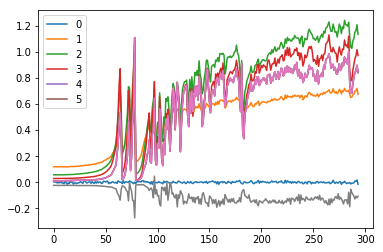

In [0]:

for l in model.act_means: 
    plt.plot(l)
plt.legend(range(6));
    
   

## Changes in std of first 6 layers  for 300 iterations

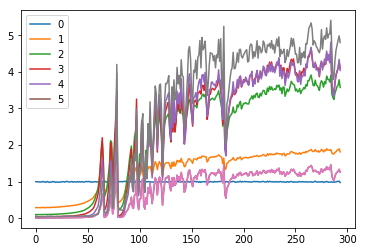

In [0]:
for l in model.act_stds: 
    plt.plot(l)
plt.legend(range(6));

## Changes in mean of first 6 layers for 10 iterations

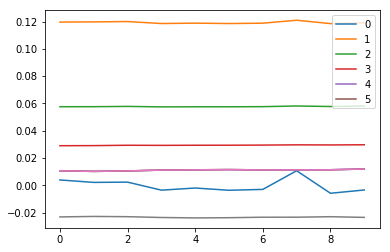

In [0]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

## Changes in std of first 6 layers for 10 iterations

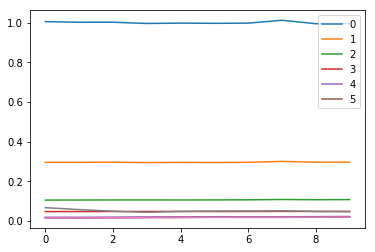

In [0]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

In [0]:
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        try: return self.items[idx]
        except TypeError:
            if isinstance(idx[0],bool):
                assert len(idx)==len(self) # bool mask
                return [o for m,o in zip(idx,self.items) if m]
            return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res
    
from torch.nn import init

def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
        
class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()
            
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    if mod.training:
        means.append(outp.data.mean())
        stds .append(outp.data.std())
        
       

In [0]:
model = nn.Sequential(*get_cnn_model(data)).cuda()
hooks = Hooks(model, append_stats)
hooks

Hooks (8 items)
[<__main__.Hook object at 0x7f62f17be978>, <__main__.Hook object at 0x7f62f17be8d0>, <__main__.Hook object at 0x7f62f17be860>, <__main__.Hook object at 0x7f62f17be128>, <__main__.Hook object at 0x7f62f17bea90>, <__main__.Hook object at 0x7f62f17beb38>, <__main__.Hook object at 0x7f62f17beb00>, <__main__.Hook object at 0x7f62f17bea58>]

In [0]:
opt = optim.SGD(model.parameters(), lr=0.9)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)
%time run.fit(1, learn)

train: [2.29618875, tensor(0.1267, device='cuda:0')]
valid: [2.2949009765625, tensor(0.1064, device='cuda:0')]
CPU times: user 953 ms, sys: 150 ms, total: 1.1 s
Wall time: 1.11 s


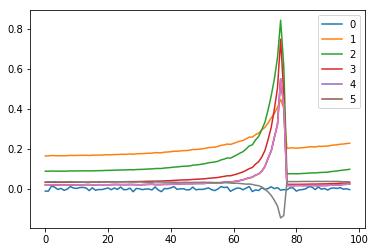

In [0]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(6));

train: [1.890308125, tensor(0.3481, device='cuda:0')]
valid: [0.618567626953125, tensor(0.8094, device='cuda:0')]
train: [0.393958984375, tensor(0.8755, device='cuda:0')]
valid: [0.2235537841796875, tensor(0.9314, device='cuda:0')]


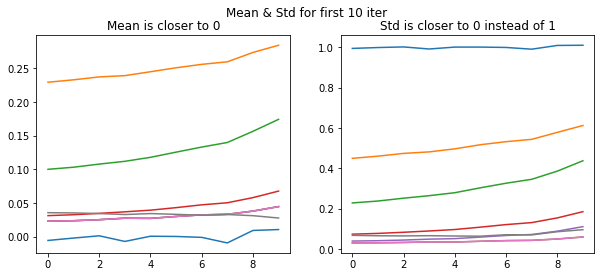

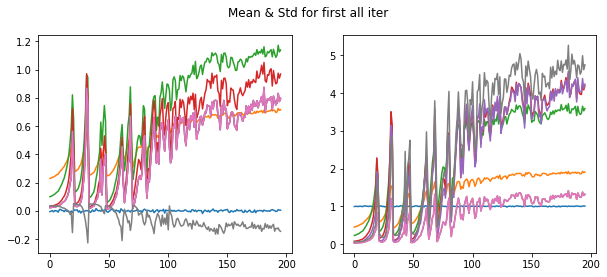

In [0]:
# 
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    plt.suptitle('Mean & Std for first 10 iter')
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    ax0.title.set_text('Mean is closer to 0')
    ax1.title.set_text('Std is closer to 0 instead of 1')
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    plt.suptitle('Mean & Std for first all iter')
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    

### We initialize model with kaiming normal initialization

In [0]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [0]:
learn = Learner(model, opt, loss_func, data)

train: [0.89291625, tensor(0.7141, device='cuda:0')]
valid: [0.222018017578125, tensor(0.9326, device='cuda:0')]
train: [0.215878359375, tensor(0.9342, device='cuda:0')]
valid: [0.15542938232421874, tensor(0.9542, device='cuda:0')]


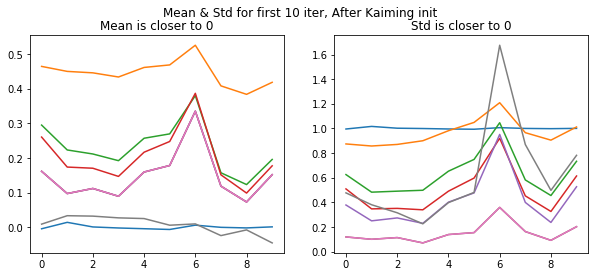

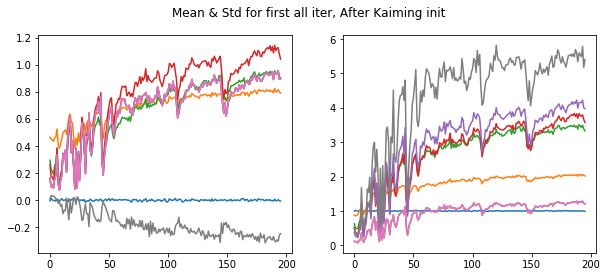

In [0]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    plt.suptitle('Mean & Std for first 10 iter, After Kaiming init')
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    ax0.title.set_text('Mean is closer to 0')
    ax1.title.set_text('Std is closer to 0')
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    plt.suptitle('Mean & Std for first all iter, After Kaiming init')
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)


Now it shows our values are starting close to zero mean & 1 std at the start of training

In [0]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): 
        hook.stats = ([], [], [])
    means, stds, hists = hook.stats
        
    if mod.training:
        means.append(outp.data.mean().cpu())
        stds.append(outp.data.std().cpu())
        # 40 bins bet 0 & 10
        hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU



In [0]:
model = nn.Sequential(*get_cnn_model(data)).cuda()
opt = optim.SGD(model.parameters(), lr=0.9)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [0]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [0]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)

train: [1.5789346875, tensor(0.4872, device='cuda:0')]
valid: [0.741936474609375, tensor(0.7719, device='cuda:0')]


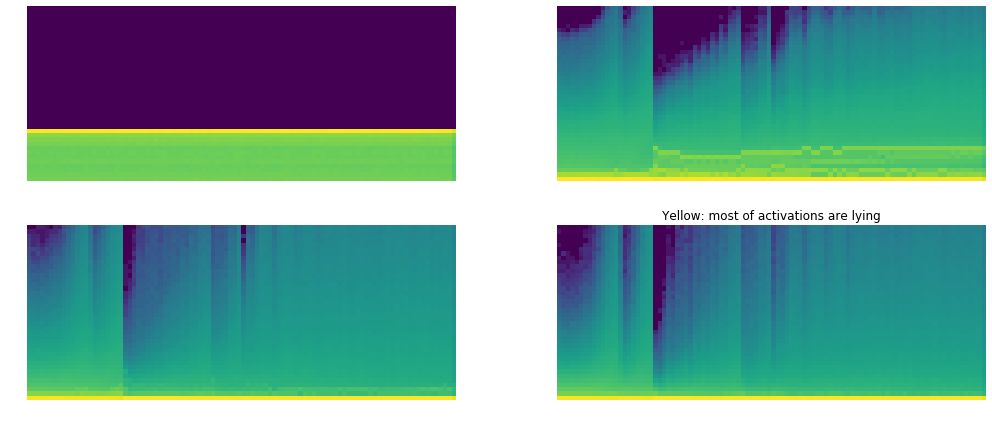

In [0]:
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
    
plt.tight_layout()


* Yellow : shows most concentration of value.
* Green : little less
* blue/black: no value.

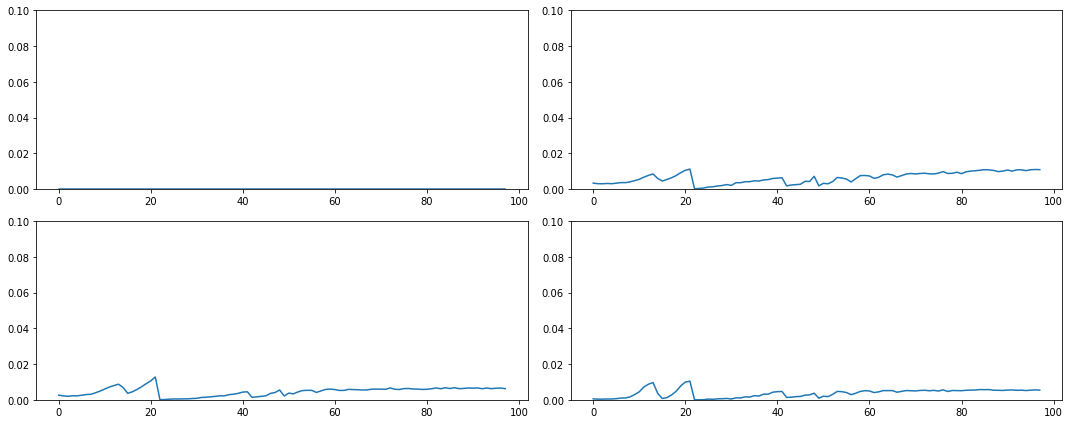

In [0]:
torch.Tensor.ndim = property(lambda x: len(x.shape))

def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,.1)
plt.tight_layout()


Most of them are filled with non zero values. But it is not giving mean 0 & std 1

# Generalized ReLU

In [0]:
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()



def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    if mod.training:
        means.append(outp.data.mean().cpu())
        stds .append(outp.data.std().cpu())
        hists.append(outp.data.cpu().histc(40,-7,7))
        
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [0]:
nfs = [8,16,32,32]
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
opt = optim.SGD(model.parameters(), lr=0.9)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

train: [0.5154879296875, tensor(0.8358, device='cuda:0')]
valid: [0.15991282958984376, tensor(0.9516, device='cuda:0')]


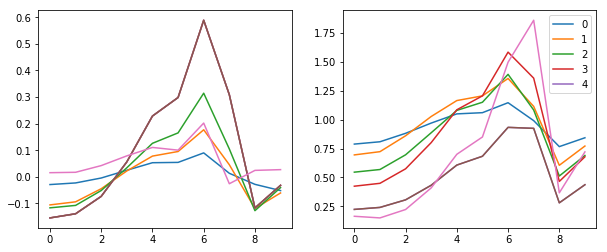

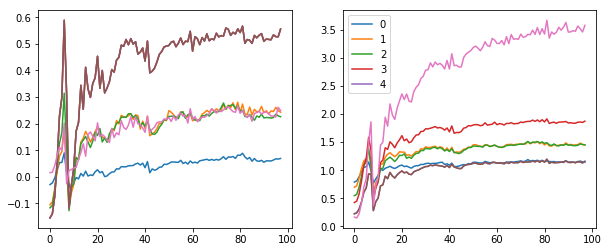

In [0]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));


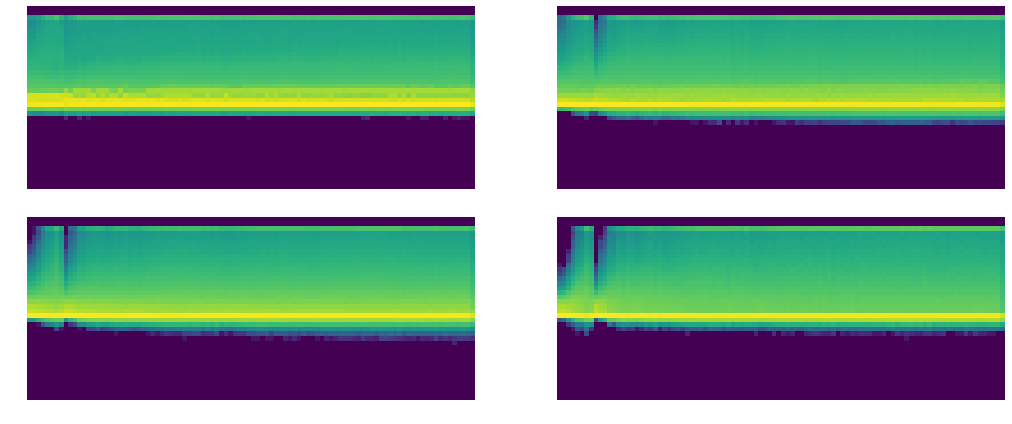

In [0]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

Most of values are in middle of Y axis

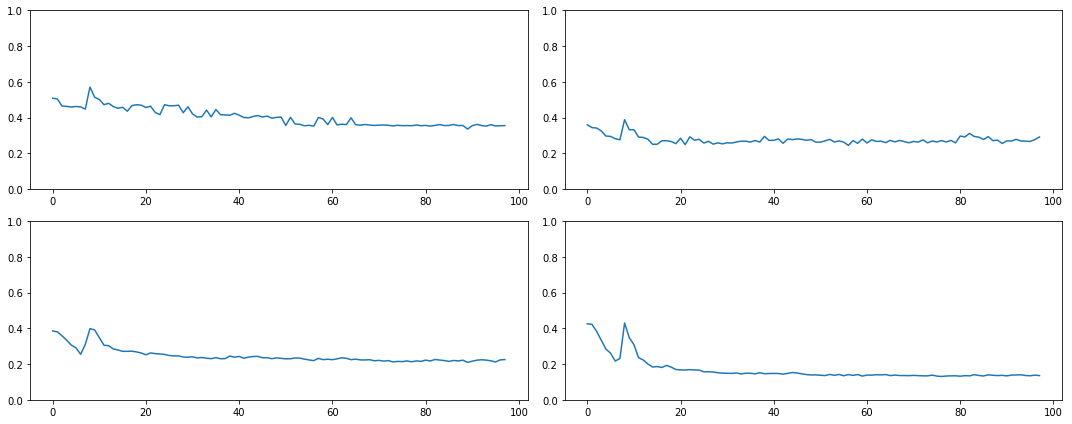

In [0]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()


now many activations are empty close to 20-40 %

In [0]:
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner


def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs

    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)

    def begin_batch(self):
        if self.in_train: self.set_param()

            
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])


In [0]:
nfs = [8,16,32,32]
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)

init_cnn(model)
opt = optim.SGD(model.parameters(), lr=0.9)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs+[partial(ParamScheduler,'lr', sched)])


In [0]:
run.fit(3, learn)

train: [0.915249296875, tensor(0.7182, device='cuda:0')]
valid: [0.2449265380859375, tensor(0.9281, device='cuda:0')]
train: [0.19559095703125, tensor(0.9404, device='cuda:0')]
valid: [0.11890172119140625, tensor(0.9652, device='cuda:0')]
train: [0.1000846484375, tensor(0.9703, device='cuda:0')]
valid: [0.09087188110351563, tensor(0.9732, device='cuda:0')]


In [0]:
run.fit(3, learn)

train: [0.087468759765625, tensor(0.9743, device='cuda:0')]
valid: [0.09696011962890624, tensor(0.9708, device='cuda:0')]
train: [nan, tensor(0.2529, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
